In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 38.9 MB/s eta 0:00:00


In [3]:
import logging
!rm "featuer-extraction.log"
!rm "preprocess-pipeline.log"

def create_log(name="preprocess-pipeline"):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    # Create a file handler
    file_handler = logging.FileHandler(f"{name}.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)

    # Add the file handler to the logger
    logger.addHandler(file_handler)

    return logger

rm: cannot remove 'featuer-extraction.log': No such file or directory
rm: cannot remove 'preprocess-pipeline.log': No such file or directory


##Feature Extraction

#Wavelet coefficents

In [4]:
featuer_log = create_log("featuer-extraction")

In [5]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from pywt import wavedec

def compute_energy(coefficients):
    if isinstance(coefficients, np.ndarray):
        return np.sum(np.square(np.abs(coefficients))) / len(coefficients)
    elif np.isscalar(coefficients):
        return np.square(np.abs(coefficients))
    else:
        raise ValueError("Unsupported type for coefficients")

def compute_total_energy(approximation_coefficients, detail_coefficients):
    total_energy = 0
    total_energy += compute_energy(approximation_coefficients)
    for detail_coefficient in detail_coefficients:
        total_energy += compute_energy(detail_coefficient)
    return total_energy

def calculate_D_Energy(detail_coefficients):
    total_energy = 0
    for detail_coefficient in detail_coefficients:
        total_energy += compute_energy(detail_coefficient)
    return total_energy


def compute_mean(coefficients):
    return np.mean(coefficients)

def compute_std(coefficients):
    return np.std(coefficients)

def calculate_D_mean(coeffs):
    valid_indices = [i for i in range(1, min(6, len(coeffs)))]
    return np.mean([np.mean(coeffs[i]) for i in valid_indices])


def calculate_A_mean(coeffs):
    return compute_mean(coeffs[0])

def calculate_D_std(coeffs):
    return np.mean([compute_std(coeffs[i]) for i in range(min(6, len(coeffs)))])

def calculate_A_std(coeffs):
    return compute_std(coeffs[0])


def wavelet_feature_extraction(data, type_wav, sampling_frequency, nperseg):
    coefficients = wavedec(data, type_wav, level=5)

    total_energy = compute_total_energy(coefficients[0], coefficients[1:])
    cD_Energy=calculate_D_Energy(coefficients[1:])
    cA_Energy=compute_energy(coefficients[0])
    cD_mean = calculate_D_mean(coefficients[1:])
    cA_mean = calculate_A_mean(coefficients[0])
    cD_std = calculate_D_std(coefficients[1:])
    cA_std = calculate_A_std(coefficients[0])

    return [
        total_energy,
        cD_Energy,
        cA_Energy,
        cD_mean,
        cA_mean,
        cD_std,
        cA_std,
    ]

  #test

#Frequency Domain coefficents

In [6]:
import scipy.signal
import numpy as np

def get_median_frequency(psd):
    median_frequency = np.median(psd)

    return median_frequency

def get_edge_frequency(psd):
    edge_frequency = np.where(psd >= psd.max() / 2)[0][0]

    return edge_frequency

def compute_power_spectral_density(data, sampling_frequency, nperseg=256):
    _, psd = scipy.signal.welch(data, fs=sampling_frequency, nperseg=nperseg)
    return psd

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

def compute_band_power(psd_result, freq_band_indices, fs, nperseg):
    freq_band_power = np.sum(psd_result[freq_band_indices]) * fs / nperseg
    return freq_band_power

def compute_spectral_entropy(psd):
    normalized_psd = psd / np.sum(psd)  # Normalize to obtain probabilities
    spectral_entropy = -np.sum(normalized_psd * np.log2(normalized_psd))
    return spectral_entropy

def extract_frequency_domain_features(signal, sampling_frequency, nperseg=256):
    # Apply Butterworth bandpass filters
    delta_band_signal = butter_bandpass_filter(signal, 0.5, 4, sampling_frequency)
    theta_band_signal = butter_bandpass_filter(signal, 4, 8, sampling_frequency)
    alpha_band_signal = butter_bandpass_filter(signal, 8, 13, sampling_frequency)
    beta_band_signal = butter_bandpass_filter(signal, 13, 30, sampling_frequency)
    gamma_band_signal = butter_bandpass_filter(signal, 30, 40, sampling_frequency)

    # Compute Power Spectral Density for each band
    delta_psd = compute_power_spectral_density(delta_band_signal, sampling_frequency, nperseg=nperseg)
    theta_psd = compute_power_spectral_density(theta_band_signal, sampling_frequency, nperseg=nperseg)
    alpha_psd = compute_power_spectral_density(alpha_band_signal, sampling_frequency, nperseg=nperseg)
    beta_psd = compute_power_spectral_density(beta_band_signal, sampling_frequency, nperseg=nperseg)
    gamma_psd = compute_power_spectral_density(gamma_band_signal, sampling_frequency, nperseg=nperseg)

    # Compute Band Power for each frequency band
    freq_band_indices = [range(int(nperseg * band[0] / sampling_frequency), int(nperseg * band[1] / sampling_frequency)) for band in [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 40)]]

    delta_band_power = compute_band_power(delta_psd, freq_band_indices[0], sampling_frequency, nperseg)
    theta_band_power = compute_band_power(theta_psd, freq_band_indices[1], sampling_frequency, nperseg)
    alpha_band_power = compute_band_power(alpha_psd, freq_band_indices[2], sampling_frequency, nperseg)
    beta_band_power = compute_band_power(beta_psd, freq_band_indices[3], sampling_frequency, nperseg)
    gamma_band_power = compute_band_power(gamma_psd, freq_band_indices[4], sampling_frequency, nperseg)

    spectral_entropy_result = compute_spectral_entropy(np.concatenate([delta_psd, theta_psd, alpha_psd, beta_psd, gamma_psd]))
    # Compute the power spectral density (PSD)
    psd, _ = scipy.signal.welch(signal, fs=sampling_frequency, nperseg=nperseg)

    return [
        delta_band_power,
        theta_band_power,
        alpha_band_power,
        beta_band_power,
        gamma_band_power,
        spectral_entropy_result,
    ]


#Time Domain coefficents

In [7]:
import numpy as np
from scipy.fft import fft
import pywt
import os
from scipy.stats import entropy, skew, kurtosis

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a
def compute_standard_deviation(data):
    return np.std(data)

def compute_skewness(data):
    return skew(data)

def compute_kurtosis(data):
    return kurtosis(data)

def compute_median(data):
    return np.median(data)

def compute_band_power_time(data, sampling_frequency, nperseg):
    _, power_density = welch(data, fs=sampling_frequency, nperseg=nperseg)
    return np.mean(power_density)
def peak_to_peak_voltage(data):
    return np.ptp(data)

def total_signal_area(data):
    return np.sum(np.abs(data))

def decorrelation_time(data):
    autocorrelation = np.correlate(data, data, mode='full')
    zero_crossings = np.where(np.diff(np.sign(autocorrelation)))[0]

    if len(zero_crossings) > 0:
        first_zero_crossing = zero_crossings[0]
        time_points = np.arange(len(autocorrelation))
        decorrelation_time = time_points[first_zero_crossing]
        return decorrelation_time
    else:
        return -1
def extract_time_domain_features(raw_data,sampling_frequency, nperseg):
    data=butter_bandpass_filter(raw_data, 0.5, 40, sampling_frequency)
    features = [
        compute_standard_deviation(data),
        compute_skewness(data),
        compute_kurtosis(data),
        compute_median(data),
        compute_band_power_time(data, sampling_frequency, nperseg),
        peak_to_peak_voltage(data),
        total_signal_area(data),
        decorrelation_time(data)
    ]
    return features

Feature extraction

In [8]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft
import pywt
import os
import pandas as pd


def calculate_mean(segments,feature_names):
    num_segments,num_channels, num_features = np.array(segments).shape
    mean_features=[]
    df = pd.DataFrame(columns=feature_names)

    for channel in range(num_channels):
      feature_array=[]
      feature_array_total=[]
      for segment in range(num_segments):
        feature_array= segments[segment][channel]

        feature_array_total.append(feature_array)
      #mean_features.append(np.mean(feature_array_total))
      a_series = pd.Series(np.mean(feature_array_total,axis=0), index=feature_names)
      df = df.append(a_series, ignore_index=True)


    return (df)

def extract_features(segment, seizure):
    num_channels, num_time_points = segment.shape
    all_features = []

    for channel_index, channel_data in enumerate(segment):
        extracted_features = []
        wavelet_name = 'db4'
        extracted_features.extend(wavelet_feature_extraction(channel_data, wavelet_name, 256, 256))
        extracted_features.extend(extract_time_domain_features(channel_data, 256, 256))
        extracted_features.extend(extract_frequency_domain_features(channel_data, 256))
        if seizure:
          extracted_features.extend([1])
        else:
          extracted_features.extend([ 0])

        all_features.append(extracted_features)

    return np.array(all_features)

def extract_features_without_segments(data, time_window_duration = 60, seizure = False):
    num_channels, num_data_points = data.shape
    data_per_segment = time_window_duration * 256
    feature_names = [  'total_energy', 'cD_Energy', 'cA_Energy', 'cD_mean', 'cA_mean', 'cD_std', 'cA_std',  'std_deviation', 'skewness', 'kurtosis', 'median', 'band_power', 'peak_to_peak_voltage',  'total_signal_area', 'decorrelation_time', 'delta_power', 'theta_power', 'alpha_power',  'beta_power', 'gamma_power', 'spectral_entropy','seizure']
    num_segments = num_data_points // data_per_segment
    all_features = []

    for i in range(num_segments):
        print('segment', i)
        features = extract_features(data[:, i * data_per_segment: (i + 1) * data_per_segment],seizure)
        all_features.append(features)
    featuer_log.info(f"äll featuers before averaging: {np.array(all_features).shape}")

    featuer_log.info(f"äll featuers after averaging: {np.array(calculate_mean(all_features,feature_names)).shape}")
    return calculate_mean(all_features,feature_names)



In [9]:
# def load_and_process_files(folder_path, time_window_duration = 60):
#     file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

#     df=pd.DataFrame(columns=feature_names)

#     for file_name in file_list:
#         file_path = os.path.join(folder_path, file_name)

#         data = np.load(file_path)
#         features = extract_features_without_segments(data, time_window_duration,feature_names)
#         df = pd.concat([df, features], ignore_index=True)

#         print('file: ',file_name)
#         del data

#     return df

# Data processing

In [10]:
preprocessing_log = create_log()

In [11]:
import re

class EEGData:
    def __init__(self, file_name, file_start_time, file_end_time, num_seizures, seizure_times=[]):
        self.file_name = file_name
        self.file_start_time = file_start_time
        self.file_end_time = file_end_time
        self.num_seizures = num_seizures
        self.seizure_times = seizure_times


    def __repr__(self):
        return (f"EEGData(File Name: {self.file_name}, "
                f"File Start Time: {self.file_start_time}, "
                f"File End Time: {self.file_end_time}, "
                f"Number of Seizures: {self.num_seizures}, "
                f"Number of Seizures: {self.seizure_times})")

In [12]:
def parse_eeg_data(file_path):
    eeg_data_objects = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
    current_file_data = {}
    num_seizures = 0
    line_index = 0
    while line_index<len(lines):
      line = lines[line_index]
      if line.startswith('File Name:'):
          if current_file_data:
              # Create EEGData object from the current_file_data
              eeg_data = EEGData(**current_file_data)
              eeg_data_objects.append(eeg_data)

              current_file_data = {}
          current_file_data['file_name'] = line.split(': ')[1].strip()
      elif line.startswith('File Start Time:'):
          current_file_data['file_start_time'] = line.split(': ')[1].strip()
      elif line.startswith('File End Time:'):
          current_file_data['file_end_time'] = line.split(': ')[1].strip()
      elif line.startswith('Number of Seizures in File:'):
          current_file_data['num_seizures'] = int(line.split(': ')[1].strip())
          num_seizures = current_file_data['num_seizures']

          seizure_times = []

          if num_seizures > 1:

            for x in range(num_seizures):
              line_index += 1
              start = int(lines[line_index].split(": ")[1].strip().split(" ")[0].strip())
              line_index += 1
              end = int(lines[line_index].split(": ")[1].strip().split(" ")[0].strip())
              seizure = (start,end)
              seizure_times.append(seizure)

          elif num_seizures  == 1:
            line_index += 1
            start = int(lines[line_index].split(": ")[1].split(" ")[0].strip())
            line_index += 1
            end = int(lines[line_index].split(": ")[1].split(" ")[0].strip())
            seizure_times.append((start,end))

          current_file_data['seizure_times'] = seizure_times

          if 'file_name' in current_file_data:
              eeg_data = EEGData(**current_file_data)
              eeg_data_objects.append(eeg_data)
              current_file_data = {}
      line_index += 1
    return eeg_data_objects


In [13]:
import glob
import mne
import gc
from tqdm import tqdm
import numpy as np

def load_data_from_file(patient_id,file_name):
  file = f"/content/drive/MyDrive/EEG-Projects/CHB-MIT/{patient_id}/{file_name}"
  data = mne.io.read_raw_edf(file)
  preprocessing_log.info(f"loaded EDF file at {file_name} with patient id : {patient_id}")
  return data

In [14]:
import random

def clean_channel_data(data_file):
  data = data_file.get_data()
  preprocessing_log.info(f"data shape before cleaning: {data.shape}")

  modified_data = []
  channel_num, data_num = data.shape
  if channel_num > 23:
    additional_channel = True
    for channel_index in range(len(data)):
      element = data[channel_index][random.randint(0,data_num-1)]

      if element != -1e-06:
        modified_data.append(data[channel_index])
      else:
        preprocessing_log.info(f"removed channel index {channel_index}")

    if len(modified_data) > 23:
      modified_data.pop(-1)
      preprocessing_log.info(f"removed ECG channel")

    new_data = np.array(modified_data)
    preprocessing_log.info(f"data shape changed from {data.shape} => {new_data.shape}")
    del modified_data,data
    gc.collect()
    return new_data

  preprocessing_log.info("data is clean")
  return data


In [15]:
def create_non_sezizer_segments(patient_id,eeg_data_objects, segment_length = 600, time_gap =300):
  count = 0
  df=pd.DataFrame()

  for i in range(len(eeg_data_objects)):
    if (int(eeg_data_objects[i].num_seizures) == 0) and i-4 >= 0 and i+3 < len(eeg_data_objects):
      preprocessing_log.info(f"[+] non-seizure: {eeg_data_objects[i]}")
      flag = True
      index = i-1
      for j in range(4):
        if eeg_data_objects[index].num_seizures != 0:
          flag = False
        index-=1
      index = i
      for k in range(3):
        if eeg_data_objects[index].num_seizures != 0:
          flag = False
        index+=1

      if flag:
        preprocessing_log.info(f"{eeg_data_objects[i]}, {eeg_data_objects[i-1]}")
        # print(eeg_data_objects[i],eeg_data_objects[i-1])
        obj1 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i].file_name))

        obj2 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i-1].file_name))

        f1_no = eeg_data_objects[i].file_name.split('_')[1].split('.')[0]
        f2_no = eeg_data_objects[i-1].file_name.split('_')[1].split('.')[0]

        concat_data = np.concatenate((obj1, obj2), axis=1)

        concat_data_selected = []
        for channel in concat_data:
          concat_data_selected.append(channel[:segment_length*256])

        concat_data_selected = np.array(concat_data_selected)
        preprocessing_log.info(f"concat data shape non-seizure: {concat_data.shape}, after selecting the range: {concat_data_selected.shape}")
        preprocessing_log.info(f"time range non-sezuer: {segment_length/3600}")


        extracted_features = extract_features_without_segments(concat_data_selected)
        df = pd.concat([df, extracted_features], ignore_index=True)
        # print(df)
        preprocessing_log.info(f"extracted featuer shape: {extracted_features.shape}")



        del obj1
        del obj2
        del concat_data,extracted_features,concat_data_selected
        gc.collect()
    elif (int(eeg_data_objects[i].num_seizures) > 0) and (i-2 >= 0):
      preprocessing_log.info(f"[+] seizure: {eeg_data_objects[i]}")
      f1_no = eeg_data_objects[i].file_name.split('_')[1].split('.')[0]
      f2_no = eeg_data_objects[i-1].file_name.split('_')[1].split('.')[0]
      flag = True


      obj1 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i].file_name))
      obj2 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i-1].file_name))
      obj3 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i-2].file_name))
      time_correction = len(obj2[0])/256 + len(obj3[0])/256
      shape_flag = False

      if obj1.shape[0] == obj2.shape[0] == obj3.shape[0]:

        shape_flag = True

      obj4 = None
      if i-3 >= 0:
        obj4 = clean_channel_data(load_data_from_file(patient_id,eeg_data_objects[i-3].file_name))
        if obj1.shape[0] != obj4.shape[0] and shape_flag == True:
          shape_flag = False

        time_correction += len(obj4[0])/256

      preprocessing_log.info(f"data shapes: {obj1.shape} {obj2.shape} {obj3.shape}")

      if shape_flag == False:
        preprocessing_log.info("Shapes doesn't match!")
        continue

      preprocessing_log.info(f"time correction: {time_correction}")

      timeline = []
      if np.all(obj4 != None):
        timeline = np.concatenate((obj4,obj3,obj2,obj1),axis=1)
      else:
        timeline = np.concatenate((obj3,obj2,obj1),axis=1)

      preprocessing_log.info(timeline.shape)

      s_count = 0
      for s in eeg_data_objects[i].seizure_times:
        seizure_data = []

        start_time = s[0] + time_correction
        end_time = s[1] + time_correction
        preprocessing_log.info(f"capture margin: {start_time} - {end_time}")

        end_margin = start_time - time_gap
        start_margin = end_margin - segment_length

        start_data_index = int(start_margin * 256)
        end_data_index = int(end_margin * 256)
        n_channels = timeline.shape[0]
        for x in range(n_channels):

          channel_data = timeline[x][start_data_index:end_data_index]
          seizure_data.append(channel_data)
        np_seizure = np.array(seizure_data,dtype=np.float32)

        preprocessing_log.info(f"pre-ictal data shape: {np_seizure.shape}")
        extracted_features = extract_features_without_segments(np_seizure, seizure=True)
        df = pd.concat([df, extracted_features], ignore_index=True)
        # print(df)

       # np.save(f"/content/drive/MyDrive/EEG-Projects/CHB-MIT-Extracted-Featuers/seizuer-cases/{patient_id}-{f1_no}-{f2_no}.npy",extracted_featuers)


        preprocessing_log.info(f"extracted featuer shape: {np.array(extracted_features).shape}")
        s_count+=1
      preprocessing_log.info(f"time range sezuer: {segment_length/3600}")
      preprocessing_log.info(f"number of sezuers: {s_count}")

      preprocessing_log.info(f"data length: {len(seizure_data)}")
      del obj1,obj2,obj3,obj4,seizure_data
      gc.collect()
    count+=1

  return df

In [16]:
def load_two_hour_segments(patient_id):
  eeg_data_objects = parse_eeg_data(f'/content/drive/MyDrive/EEG-Projects/CHB-MIT/{patient_id}/{patient_id}-summary.txt')
  df=create_non_sezizer_segments(patient_id,eeg_data_objects)
  del eeg_data_objects
  gc.collect
  return df

In [17]:
gc.collect()

0

In [18]:

# create_log()


In [19]:
# patient_id = "chb13"
# load_two_hour_segments(patient_id)

In [20]:
# feature_names = [  'total_energy', 'cD_Energy', 'cA_Energy', 'cD_mean', 'cA_mean', 'cD_std', 'cA_std',  'std_deviation', 'skewness', 'kurtosis', 'median', 'band_power', 'peak_to_peak_voltage',  'total_signal_area', 'decorrelation_time', 'delta_power', 'theta_power', 'alpha_power',  'beta_power', 'gamma_power', 'spectral_entropy','seizure']
# df=pd.DataFrame(columns=feature_names)

# for i in range(2):
#   patient_id = f"chb{i+1:02d}"
#   patient_df=load_two_hour_segments(patient_id)
#   df = pd.concat([df, patient_df], ignore_index=True)



In [24]:
import os

# Assuming 'output_folder' is the path to the folder where you want to save the DataFrame
output_folder = '/content/drive/MyDrive/EEG-Projects/CHB-MIT-Extracted-Featuers/'
os.makedirs(output_folder, exist_ok=True)

feature_names = ['total_energy', 'cD_Energy', 'cA_Energy', 'cD_mean', 'cA_mean', 'cD_std', 'cA_std',
                 'std_deviation', 'skewness', 'kurtosis', 'median', 'band_power', 'peak_to_peak_voltage',
                 'total_signal_area', 'decorrelation_time', 'delta_power', 'theta_power', 'alpha_power',
                 'beta_power', 'gamma_power', 'spectral_entropy', 'seizure']

# Load the existing DataFrame from the intermediate CSV file, if it exists
intermediate_file_path = os.path.join(output_folder, 'intermediate_dataframe10.csv')
if os.path.exists(intermediate_file_path):
    df = pd.read_csv(intermediate_file_path)
else:
    df = pd.DataFrame(columns=feature_names)

# Iterate over batches of patients (e.g., 3 patients at a time)


for i in range(22,23):
    patient_id = f"chb{i+1:02d}"
    patient_df = load_two_hour_segments(patient_id)
    df = pd.concat([df, patient_df], ignore_index=True)
    df.to_csv(intermediate_file_path, index=False)

      # Save the DataFrame to the intermediate CSV file after processing each batch

print(f"Intermediate DataFrame saved to: {intermediate_file_path}")




INFO:preprocess-pipeline:[+] seizure: EEGData(File Name: chb23_08.edf, File Start Time: 11:48:05, File End Time: 14:40:27, Number of Seizures: 2, Number of Seizures: [(325, 345), (5104, 5151)])


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_08.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 2647552)
INFO:preprocess-pipeline:data is clean


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_07.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 655360)
INFO:preprocess-pipeline:data is clean


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_06.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 1916416)
INFO:preprocess-pipeline:data is clean
INFO:preprocess-pipeline:data shapes: (23, 2647552) (23, 655360) (23, 1916416)
INFO:preprocess-pipeline:time correction: 10046.0
INFO:preprocess-pipeline:(23, 5219328)
INFO:preprocess-pipeline:capture margin: 10371.0 - 10391.0
INFO:preprocess-pipeline:pre-ictal data shape: (23, 153600)


segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_09.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 3693056)
INFO:preprocess-pipeline:data is clean


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_08.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 2647552)
INFO:preprocess-pipeline:data is clean


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_07.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 655360)
INFO:preprocess-pipeline:data is clean


Extracting EDF parameters from /content/drive/MyDrive/EEG-Projects/CHB-MIT/chb23/chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-5c87bc86bad2>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
INFO:preprocess-pipeline:loaded EDF file at chb23_06.edf with patient id : chb23
INFO:preprocess-pipeline:data shape before cleaning: (23, 1916416)
INFO:preprocess-pipeline:data is clean
INFO:preprocess-pipeline:data shapes: (23, 3693056) (23, 2647552) (23, 655360)
INFO:preprocess-pipeline:time correction: 20388.0
INFO:preprocess-pipeline:(23, 8912384)
INFO:preprocess-pipeline:capture margin: 22977.0 - 23048.0
INFO:preprocess-pipeline:pre-ictal data shape: (23, 153600)


segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

segment 0
segment 1
segment 2
segment 3
segment 4
segment 5
segment 6
segment 7
segment 8
segment 9


INFO:featuer-extraction:äll featuers before averaging: (10, 23, 22)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(a_series, ignore_index=True)
<ipython-input-8-0e4f9e770a73>:23: FutureWarning: The frame.append method is

Intermediate DataFrame saved to: /content/drive/MyDrive/EEG-Projects/CHB-MIT-Extracted-Featuers/intermediate_dataframe10.csv


In [25]:
data=pd.read_csv('/content/drive/MyDrive/EEG-Projects/CHB-MIT-Extracted-Featuers/intermediate_dataframe10.csv')

In [26]:
data

,total_energy,cD_Energy,cA_Energy,cD_mean,cA_mean,cD_std,cA_std,std_deviation,skewness,kurtosis,...,peak_to_peak_voltage,total_signal_area,decorrelation_time,delta_power,theta_power,alpha_power,beta_power,gamma_power,spectral_entropy,seizure
0,1.049129e-08,2.964715e-09,7.526573e-09,-1.058221e-06,-0.000041,0.000018,0.0,0.000018,0.000043,1.913422,...,0.000188,0.208586,21.0,1.724271e-10,6.901304e-11,1.475933e-11,2.435610e-11,7.009636e-12,3.955932,1.0
1,9.942815e-09,2.602781e-09,7.340034e-09,-2.130085e-07,0.000005,0.000016,0.0,0.000017,-0.069634,1.155495,...,0.000167,0.202015,16.5,1.688063e-10,6.410938e-11,1.274803e-11,1.533214e-11,2.343582e-12,3.804794,1.0
2,1.514415e-08,3.832308e-09,1.131184e-08,2.809866e-07,-0.000057,0.000019,0.0,0.000021,0.027133,0.563959,...,0.000177,0.250748,22.0,2.640359e-10,9.601031e-11,2.136760e-11,1.223541e-11,1.767946e-12,3.615178,1.0
3,1.241042e-08,3.621845e-09,8.788571e-09,6.408471e-07,-0.000047,0.000018,0.0,0.000020,-0.088474,0.620514,...,0.000167,0.236297,28.6,2.359125e-10,8.217361e-11,2.774180e-11,1.162628e-11,4.464775e-12,3.756513,1.0
4,2.222277e-08,5.579810e-09,1.664296e-08,-1.019392e-06,-0.000022,0.000024,0.0,0.000026,-0.127484,1.499476,...,0.000269,0.307929,25.4,4.305053e-10,1.219061e-10,2.998843e-11,5.046479e-11,6.630836e-12,3.793919,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525,2.027833e-08,7.585310e-09,1.269302e-08,-9.920035e-08,0.000006,0.000034,0.0,0.000028,-0.091289,3.734627,...,0.000443,0.316461,9.3,2.995850e-10,8.269829e-11,5.613392e-11,1.768083e-10,1.793340e-10,5.007138,1.0
8526,3.090306e-08,6.970973e-09,2.393209e-08,-3.016931e-07,-0.000008,0.000033,0.0,0.000031,-0.215242,8.209278,...,0.000556,0.336778,17.3,4.960294e-10,9.346872e-11,4.623408e-11,1.558594e-10,1.422658e-10,4.532870,1.0
8527,1.230807e-07,1.071696e-08,1.123637e-07,3.430732e-07,0.000030,0.000036,0.0,0.000055,0.004106,2.478789,...,0.000540,0.599621,28.5,2.196072e-09,2.113952e-10,6.503936e-11,8.926678e-11,4.833307e-11,3.117688,1.0
8528,2.815954e-08,4.664681e-09,2.349486e-08,-7.231024e-08,-0.000056,0.000026,0.0,0.000028,0.233226,12.561774,...,0.000468,0.298937,25.1,4.794291e-10,8.474286e-11,3.423864e-11,6.942805e-11,4.276092e-11,3.979549,1.0


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [28]:
null_data_summary = data.isnull().sum()
print("Null Data Summary:")
print(null_data_summary)

Null Data Summary:
total_energy             0
cD_Energy                0
cA_Energy                0
cD_mean                  0
cA_mean                  0
cD_std                   0
cA_std                   0
std_deviation            0
skewness                65
kurtosis                65
median                   0
band_power               0
peak_to_peak_voltage     0
total_signal_area        0
decorrelation_time       0
delta_power              0
theta_power              0
alpha_power              0
beta_power               0
gamma_power              0
spectral_entropy        65
seizure                  0
dtype: int64


In [38]:
 data.dropna(inplace=True)

In [39]:
print(data.isnull().sum())

total_energy            0
cD_Energy               0
cA_Energy               0
cD_mean                 0
cA_mean                 0
cD_std                  0
cA_std                  0
std_deviation           0
skewness                0
kurtosis                0
median                  0
band_power              0
peak_to_peak_voltage    0
total_signal_area       0
decorrelation_time      0
delta_power             0
theta_power             0
alpha_power             0
beta_power              0
gamma_power             0
spectral_entropy        0
seizure                 0
dtype: int64


<Figure size 1500x1000 with 0 Axes>

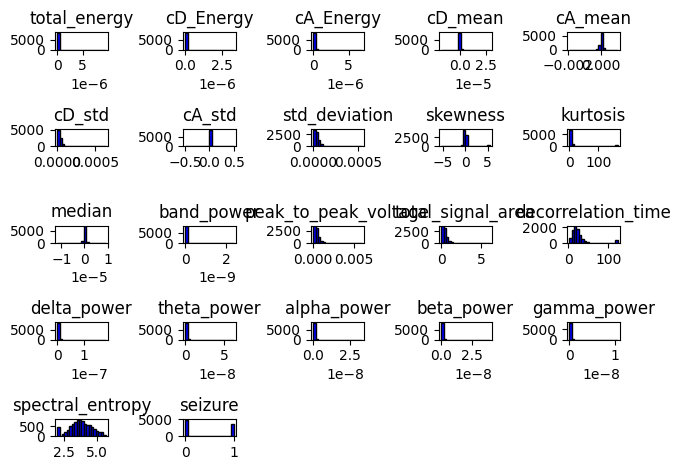

In [40]:
plt.figure(figsize=(15, 10))
data.hist(bins=20, color='blue', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

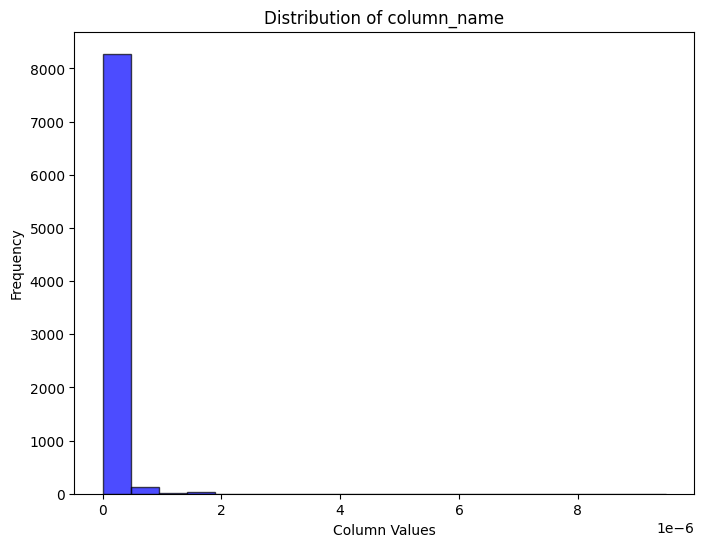

In [34]:
import matplotlib.pyplot as plt

column_names = ['total_energy', 'cD_Energy', 'cA_Energy', 'cD_mean', 'cA_mean', 'cD_std', 'cA_std',
                 'std_deviation', 'skewness', 'kurtosis', 'median', 'band_power', 'peak_to_peak_voltage',
                 'total_signal_area', 'decorrelation_time', 'delta_power', 'theta_power', 'alpha_power',
                 'beta_power', 'gamma_power', 'spectral_entropy', 'seizure']

# Plot the distribution of a specific column (replace 'column_name' with the actual column name)
plt.figure(figsize=(8, 6))
plt.hist(data['total_energy'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of column_name')
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [41]:
print(data['cA_std'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8525    0.0
8526    0.0
8527    0.0
8528    0.0
8529    0.0
Name: cA_std, Length: 8465, dtype: float64


In [69]:
# Separate features and target variable
y = data['seizure']

X = data.drop('cA_std', axis=1)

In [72]:
X = X.drop('seizure', axis=1)

KeyError: ignored

In [78]:
X= X.drop('cA_std',axis=1)

In [79]:
X

,total_energy,cD_Energy,cA_Energy,cD_mean,cA_mean,cD_std,std_deviation,skewness,kurtosis,median,band_power,peak_to_peak_voltage,total_signal_area,decorrelation_time,delta_power,theta_power,alpha_power,beta_power,gamma_power,spectral_entropy
0,1.049129e-08,2.964715e-09,7.526573e-09,-1.058221e-06,-0.000041,0.000018,0.000018,0.000043,1.913422,8.505168e-08,2.439230e-12,0.000188,0.208586,21.0,1.724271e-10,6.901304e-11,1.475933e-11,2.435610e-11,7.009636e-12,3.955932
1,9.942815e-09,2.602781e-09,7.340034e-09,-2.130085e-07,0.000005,0.000016,0.000017,-0.069634,1.155495,1.447289e-07,2.243040e-12,0.000167,0.202015,16.5,1.688063e-10,6.410938e-11,1.274803e-11,1.533214e-11,2.343582e-12,3.804794
2,1.514415e-08,3.832308e-09,1.131184e-08,2.809866e-07,-0.000057,0.000019,0.000021,0.027133,0.563959,1.008045e-07,3.395315e-12,0.000177,0.250748,22.0,2.640359e-10,9.601031e-11,2.136760e-11,1.223541e-11,1.767946e-12,3.615178
3,1.241042e-08,3.621845e-09,8.788571e-09,6.408471e-07,-0.000047,0.000018,0.000020,-0.088474,0.620514,3.855326e-07,3.067333e-12,0.000167,0.236297,28.6,2.359125e-10,8.217361e-11,2.774180e-11,1.162628e-11,4.464775e-12,3.756513
4,2.222277e-08,5.579810e-09,1.664296e-08,-1.019392e-06,-0.000022,0.000024,0.000026,-0.127484,1.499476,4.049203e-07,5.503283e-12,0.000269,0.307929,25.4,4.305053e-10,1.219061e-10,2.998843e-11,5.046479e-11,6.630836e-12,3.793919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525,2.027833e-08,7.585310e-09,1.269302e-08,-9.920035e-08,0.000006,0.000034,0.000028,-0.091289,3.734627,1.182829e-07,6.595067e-12,0.000443,0.316461,9.3,2.995850e-10,8.269829e-11,5.613392e-11,1.768083e-10,1.793340e-10,5.007138
8526,3.090306e-08,6.970973e-09,2.393209e-08,-3.016931e-07,-0.000008,0.000033,0.000031,-0.215242,8.209278,1.662136e-07,7.657948e-12,0.000556,0.336778,17.3,4.960294e-10,9.346872e-11,4.623408e-11,1.558594e-10,1.422658e-10,4.532870
8527,1.230807e-07,1.071696e-08,1.123637e-07,3.430732e-07,0.000030,0.000036,0.000055,0.004106,2.478789,1.092535e-08,2.128712e-11,0.000540,0.599621,28.5,2.196072e-09,2.113952e-10,6.503936e-11,8.926678e-11,4.833307e-11,3.117688
8528,2.815954e-08,4.664681e-09,2.349486e-08,-7.231024e-08,-0.000056,0.000026,0.000028,0.233226,12.561774,-1.142858e-07,5.964995e-12,0.000468,0.298937,25.1,4.794291e-10,8.474286e-11,3.423864e-11,6.942805e-11,4.276092e-11,3.979549


In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
y_train

8461    1.0
5994    1.0
4740    0.0
6526    0.0
3692    0.0
       ... 
5734    1.0
5191    1.0
5390    1.0
860     0.0
7270    1.0
Name: seizure, Length: 6772, dtype: float64

In [82]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
# Create and train an SVM model
svm_model_linear = SVC(kernel='linear', random_state=42)
svm_model_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [84]:
# Make predictions on the test set
y_pred = svm_model_linear.predict(X_test_scaled)


In [85]:
accuracy = accuracy_score(y_test, y_pred)

In [86]:
print(accuracy)

0.6012994683992912


In [87]:
# Create and train an SVM model
svm_model_rbf = SVC(kernel='rbf', random_state=42)
svm_model_rbf.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [88]:
# Make predictions on the test set
y_pred_rbf = svm_model_rbf.predict(X_test_scaled)


In [90]:
accuracy_rbf= accuracy_score(y_test, y_pred_rbf)

In [91]:
print(accuracy_rbf)

0.6320141760189013


In [93]:
svm_rbf_gamma = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm_rbf_gamma.fit(X_train_scaled, y_train)
y_pred_rbf_gamma = svm_model_rbf.predict(X_test_scaled)
accuracy_rbf_gamma= accuracy_score(y_test, y_pred_rbf)
print(accuracy_rbf_gamma)

0.6320141760189013


In [95]:
from sklearn.model_selection import  GridSearchCV

# Define a parameter grid for Grid Search
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

# Create an SVM model with the RBF kernel
svm_model_param = SVC(kernel='rbf', random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(svm_model_param, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_svm_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_param = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Hyperparameters: {accuracy_param}")

Best Hyperparameters: {'C': 10, 'gamma': 1}
Accuracy with Best Hyperparameters: 0.7412876550502068


In [98]:
best_svm_model = SVC(kernel='rbf', C=10, gamma=0.9, random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_param = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Hyperparameters: {accuracy_param}")

Accuracy with Best Hyperparameters: 0.7424689899586533


In [99]:
param_grid = {'C': [0.1, 1, 10], 'gamma': np.arange(0.8, 1.05, 0.05)}

# Create an SVM model with the RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_svm_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Hyperparameters: {accuracy}")

Best Hyperparameters: {'C': 10, 'gamma': 0.8500000000000001}
Accuracy with Best Hyperparameters: 0.7412876550502068
